In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/drive/MyDrive/Datasets/bc_numeric.csv'

bc_df = pd.read_csv(PATH)

#### A little bit of preproc.
Nota para mi: No ejecutar si estás cargando el archivo bc_numeric.csv, que ya tiene las filas reducidas

In [ ]:
# Count the number of occurrences for each unique value in the 'Status' column
status_counts = bc_df['Status'].value_counts()
min_status_count = min(status_counts)

# Randomly sample half of the rows for each unique value in the 'Status' column
bccut_df = pd.concat(
    [bc_df[bc_df['Status'] == status].sample(n=min_status_count // 20, random_state=1) for status in status_counts.index]
).reset_index(drop=True)

# Display the first few rows of the sampled DataFrame and its shape
# bccut_df.to_csv('/content/drive/MyDrive/Datasets/bc_numeric.csv', index=False)

In [ ]:
aux = pd.concat([bccut_df.iloc[:5, :], bccut_df.iloc[-5:, :]], ignore_index=True)

print(aux.to_latex(index=False,
                  float_format="{:.1f}".format,
))

\begin{tabular}{rrrrrr}
\toprule
 Age &  Tumor Size &  Regional Node Examined &  Reginol Node Positive &  Survival Months &  Status \\
\midrule
  48 &          35 &                      15 &                      3 &               91 &       1 \\
  48 &           8 &                       5 &                      1 &               72 &       1 \\
  67 &          18 &                      11 &                      1 &              103 &       1 \\
  47 &          20 &                      23 &                      1 &              102 &       1 \\
  61 &          16 &                      16 &                      1 &               96 &       1 \\
  46 &          33 &                      13 &                      4 &               82 &       0 \\
  60 &          75 &                       9 &                      6 &               63 &       0 \\
  66 &          16 &                       3 &                      1 &               60 &       0 \\
  61 &          21 &                    

<ipython-input-15-45de4c9478ea>:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(aux.to_latex(index=False,


# Visualization of variables

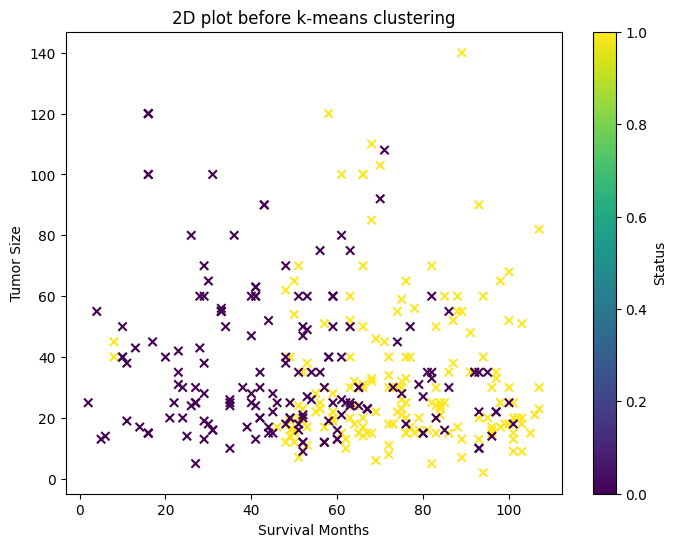

In [ ]:
# Selecting important features for plotting
# Interesante: ['Survival Months', 'Tumor Size']
features_2D = ['Survival Months', 'Tumor Size']


# Extracting the values for plotting
X_2D = bc_df[features_2D].values
y = bc_df['Status'].values  # Target labels for coloring

# 2D Plot before k-means
plt.figure(figsize=(8, 6))
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=y, cmap='viridis', marker='x')
plt.title('2D plot before k-means clustering')
plt.xlabel(features_2D[0])
plt.ylabel(features_2D[1])
plt.colorbar(label='Status')
plt.show()

# K-means clustering

In [ ]:
# Function to calculate Euclidean distance between two points
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2)**2))

# Function to calculate the Mean Squared Error (MSE) for the centroids and clusters
def calculate_mse(centroids, clusters):
    mse = 0
    for i in range(len(centroids)):
        mse += np.sum((clusters[i] - centroids[i]) ** 2)
    mse = mse / len(centroids)
    return mse

# Main function to perform k-means clustering
def k_means(X, k, max_iters=100):
    # Step 1: Initialize centroids randomly from the data points
    indices = np.random.choice(len(X), k, replace=False)
    centroids = X[indices]

    for _ in range(max_iters):
        # Step 2: Assign each data point to the closest centroid
        clusters = {}
        for i in range(k):
            clusters[i] = []

        for point in X:
            distances = [euclidean_distance(point, centroid) for centroid in centroids]
            cluster = np.argmin(distances)
            clusters[cluster].append(point)

        # Convert list to NumPy arrays for easier numeric operations
        for i in range(k):
            clusters[i] = np.array(clusters[i])

        # Step 3: Update centroids
        prev_centroids = centroids.copy()
        for i in range(k):
            centroids[i] = np.mean(clusters[i], axis=0)

        # Step 4: Check for convergence using MSE as the error measure
        mse = calculate_mse(centroids, clusters)
        if mse < 1e-5:
            print("Algorithm has converged")
            break

    return centroids, clusters


In [ ]:
from matplotlib.colors import ListedColormap

# Define a function to plot decision boundaries with custom colors
def plot_decision_boundary_custom_colors(X, centroids, cluster_labels, title):
    # Generate a mesh grid for the decision boundary
    h = 1  # Mesh grid step size
    x_min, x_max = X[:, 0].min() - 10, X[:, 0].max() + 10
    y_min, y_max = X[:, 1].min() - 10, X[:, 1].max() + 10
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Classify each grid point based on the closest centroid
    Z = np.zeros(xx.shape)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            point = np.array([xx[i, j], yy[i, j]])
            distances = [euclidean_distance(point, centroid) for centroid in centroids]
            Z[i, j] = np.argmin(distances)

    # Create plot
    plt.figure(figsize=(10, 7))
    cmap_background = ListedColormap(['#D3D3D3', '#FFFF00'])  # Custom colors to match clusters
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_background)
    plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='viridis', edgecolor='k', label='Data points')
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', label='Centroids')
    plt.xlabel('Survival Months')
    plt.ylabel('Tumor Size')
    plt.title(title)
    plt.colorbar(label='Cluster')
    plt.legend()
    plt.show()

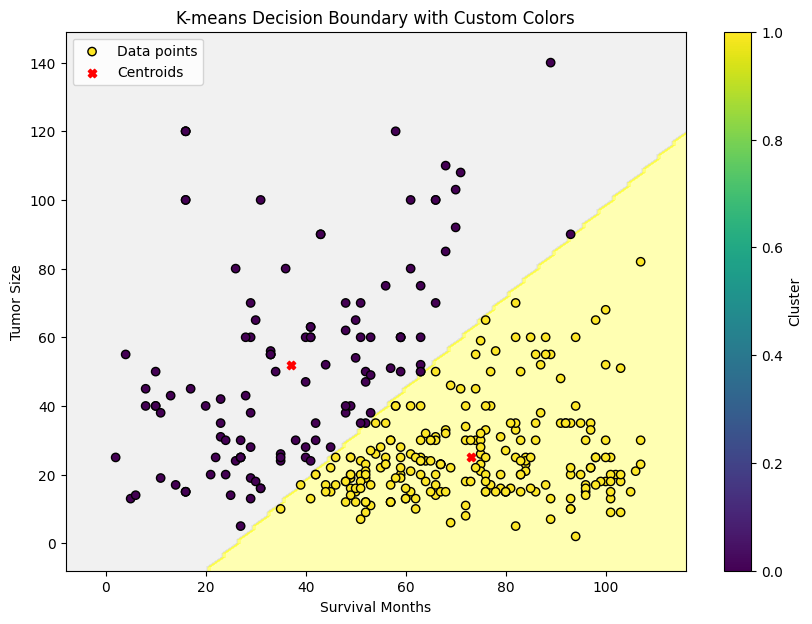

In [ ]:
X = bc_df[['Survival Months', 'Tumor Size']].values

centroids, clusters = k_means(X, 2)
final_cluster_labels_fixed = np.zeros(len(X))

for i in range(2):

    final_cluster_indices_fixed = np.all(X == clusters[i][:, None], axis=2).any(axis=0)

    final_cluster_labels_fixed[final_cluster_indices_fixed] = i
# Plot decision boundary with custom background colors
plot_decision_boundary_custom_colors(X, centroids, final_cluster_labels_fixed, 'K-means Decision Boundary with Custom Colors')

#### Performance!! (oh no)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


status_labels = bc_df['Status'].values
cluster_labels = np.zeros(len(X))
# Assign cluster labels based on the nearest centroid
k = 2 # Number of clusters
for i in range(k):
    cluster_indices = np.all(X == clusters[i][:, None], axis=2).any(axis=0)
    cluster_labels[cluster_indices] = i


# Convert cluster labels to align with 'Status' labels (1 for alive, 0 for deceased)
# We determine this by checking which cluster has more 'alive' labels and assigning it as '1'
cluster_0_alive = np.sum(status_labels[cluster_labels == 0])
cluster_1_alive = np.sum(status_labels[cluster_labels == 1])

# Align cluster labels with 'Status' labels
if cluster_0_alive < cluster_1_alive:
    cluster_labels = 1 - cluster_labels

# Align cluster labels with 'Status' labels based on our observation
# Cluster 0 corresponds to 'Status' 1 and Cluster 1 corresponds to 'Status' 0
aligned_cluster_labels = 1 - cluster_labels

# Re-evaluate the performance
accuracy = accuracy_score(status_labels, aligned_cluster_labels)
precision = precision_score(status_labels, aligned_cluster_labels)
recall = recall_score(status_labels, aligned_cluster_labels)
f1 = f1_score(status_labels, aligned_cluster_labels)

print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1-Score: {f1}')


Accuracy: 0.7058823529411765
Precision: 0.65625
Recall: 0.8647058823529412
F1-Score: 0.7461928934010152
